# Using NLP to analyse Competitor Gym reviews

### Import Packages and Datasets

In [ ]:
# For dataframes
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importing all nltk related libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('all')
nltk.download('vader_lexicon')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Sentiment Analysis
from textblob import TextBlob

# Regular Expressions
import re
import string

# Wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

# CountVectorizer, LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from collections import Counter

# To ignore warning
import warnings
warnings.filterwarnings("ignore")


In [5]:
fitness_first_reviews = pd.read_csv('filtered-datasets/fitness-first-reviews.csv')
fitness_first_reviews.shape

(488, 6)

In [6]:
virgin_active_reviews = pd.read_csv('filtered-datasets/virgin-active-reviews.csv')
virgin_active_reviews.shape

(445, 6)

### Data Preparation
Use Text Processing Techniques to clean and prepare the text data for analysis.

In [7]:
# Setting lemmatizer variable
lemmatizer = WordNetLemmatizer()
stopword = set(stopwords.words('english'))

# Processing Review data 
def review_processor(review_data):
  # Changing all tweet texts to be lowercase
  review_data = review_data.lower()

  # Removing punctuation
  review_data = re.sub('\[.*?\]', '', review_data)

  # Removing special characters and numbers
  review_data = re.sub("[^a-z\s]", "", review_data)

  # Removing hashtags
  review_data = re.sub("#", " ", review_data)

  # Removing RT
  review_data = re.sub("RT[\s]+", "", review_data)

  # Removing hyperlinks
  review_data = re.sub('https?://\S+|www\.\S+', '', review_data)

  review_data = re.sub('<.*?>+', '', review_data)

  review_data = re.sub('[%s]' % re.escape(string.punctuation), '', review_data)

  # Removing lines separated by \n
  review_data = re.sub('\n', '', review_data)

  # Removing usernames
  review_data = re.sub('\w*\d\w*', '', review_data)

  # Removing stopwords
  review_data = [word for word in review_data.split(' ') if word not in stopword]
  review_data = " ".join(review_data)

  # Lemmatisation
  review_data = [lemmatizer.lemmatize(word) for word in review_data.split(' ')]
  review_data = " ".join(review_data)
  # review_data = ",".join([str(i) for i in review_data])
  return review_data

In [8]:
# Subjectivity of the processed data from 0 to 1, 0 means neutral/facts, 1 means personal opinion
# Create a function to get the subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Polarity of the processed data from -1 to 1, -1 means negative, 0 means neutral, 1 means positive
# Create a function to get the polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

# Computing negative, neutral and positive analysis
def getComputation(score):
    if score < -0.5:
        return 'Very Negative'
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    elif score > 0:
        return 'Positive'

#### Fitness First

In [9]:
# Create a copy of the DataFrame to avoid modifying the original
ff_reviews = fitness_first_reviews.copy()

# Create columns for Processed_Review, Subjectivity, Polarity, Computation_Analysis
ff_reviews['Processed_Review'] = ff_reviews['review'].apply(review_processor)
ff_reviews['Subjectivity'] = ff_reviews['Processed_Review'].apply(getSubjectivity)
ff_reviews['Polarity'] = ff_reviews['Processed_Review'].apply(getPolarity)
ff_reviews['Computation_Analysis'] = ff_reviews['Polarity'].apply(getComputation)

ff_reviews.head(2)

review  rating            gym  \
0  Air In the gym very smelly gym never place air...       1  Fitness First   
1  This club doesnt even deserve one star rating ...       1  Fitness First   

        branch  length  year  \
0  Junction 10     233  2024   
1  Junction 10     409  2024   

                                    Processed_Review  Subjectivity  Polarity  \
0  air gym smelly gym never place air purifier to...      0.633333 -0.433333   
1  club doesnt even deserve one star rating gym d...      0.555556 -0.025000   

  Computation_Analysis  
0             Negative  
1             Negative

#### Virgin Active

In [15]:
# Create a copy of the DataFrame to avoid modifying the original
va_reviews = virgin_active_reviews.copy()

# Create columns for Processed_Review, Subjectivity, Polarity, Computation_Analysis
va_reviews['Processed_Review'] = va_reviews['review'].apply(review_processor)
va_reviews['Processed_Review'] = va_reviews['review'].apply(review_processor)
va_reviews['Subjectivity'] = va_reviews['Processed_Review'].apply(getSubjectivity)
va_reviews['Polarity'] = va_reviews['Processed_Review'].apply(getPolarity)
va_reviews['Computation_Analysis'] = va_reviews['Polarity'].apply(getComputation)

va_reviews.head(2)

review  rating            gym  \
0  The people at the counters are super nice & ac...       5  Virgin Active   
1  Started trial pass this week and attended my f...       5  Virgin Active   

       branch  length  year  \
0  Paya Lebar     140  2024   
1  Paya Lebar     211  2024   

                                    Processed_Review  Subjectivity  Polarity  \
0  people counter super nice  accommodating equip...      0.545238  0.347619   
1  started trial pas week attended first reformer...      0.381667  0.230000   

  Computation_Analysis  
0             Positive  
1             Positive

### Part 1: Keyword Frequency Trends Over the Years

In [18]:
def get_keyword_counts(text):
    vectorizer = CountVectorizer(stop_words='english')
    word_counts = vectorizer.fit_transform([text])
    keywords = vectorizer.get_feature_names_out()
    counts = word_counts.toarray().flatten()
    return dict(zip(keywords, counts))

#### Fitness First

In [30]:
# Create a copy of the DataFrame to avoid modifying the original
ff_reviews_copy = ff_reviews.copy()
 
# Filter data to only include rows from 2017 onwards
ff_reviews_copy = ff_reviews_copy[ff_reviews_copy['year'] >= 2017]

# Combine reviews by year
ff_reviews_by_year = ff_reviews_copy.groupby('year')['review'].apply(lambda x: ' '.join(x)).reset_index()

# Tokenize and count words for each year
ff_reviews_by_year['keyword_counts'] = ff_reviews_by_year['review'].apply(get_keyword_counts)

In [31]:
# Flatten keyword counts across all years for comparison
all_keywords = Counter()
for counts in ff_reviews_by_year['keyword_counts']:
    all_keywords.update(counts)

# Focus on top 10 frequent keywords overall
ff_top_keywords = [word for word, freq in all_keywords.most_common(10)]

# Create a frequency table for top keywords by year
ff_keyword_trends = {}
for keyword in ff_top_keywords:
    ff_keyword_trends[keyword] = ff_reviews_by_year['keyword_counts'].apply(lambda x: x.get(keyword, 0)).tolist()

# Convert trends to DataFrame for visualization
ff_keyword_trends = pd.DataFrame(ff_keyword_trends, index=ff_reviews_by_year['year'])
print(ff_keyword_trends)

      gym  fitness  staff  great  friendly  good  positive  professionalism  \
year                                                                          
2017    9        2      5      7         6     6         0                0   
2018   23        4      4      6         4    12         0                0   
2019   32        4      7      8         3     7         0                0   
2020   11        2      6      3         5     1         1                1   
2021   16        4     21     12        27    16        65               56   
2022   35       27     16     29        21    18         7                6   
2023   43       34     35     29        22    16         3                1   
2024   44       44     25     16        19    16         4                3   

      place  pool  
year               
2017      7     7  
2018      2     6  
2019      5    10  
2020      2     5  
2021     12     4  
2022     10    13  
2023     17     9  
2024      7     8  


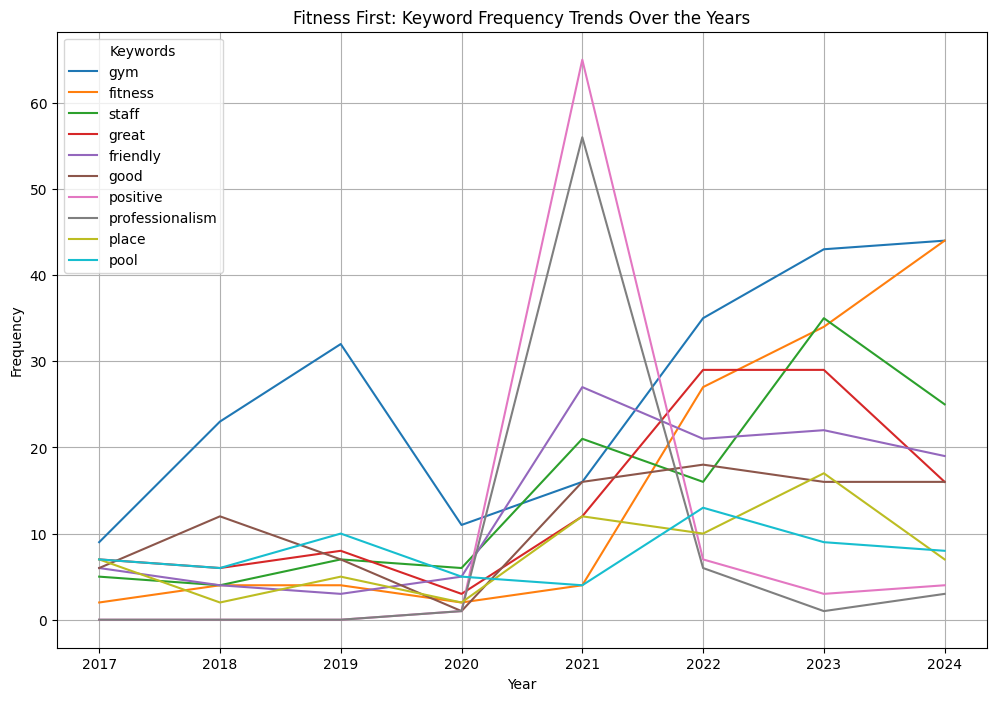

In [32]:
# Line plot for keyword trends
plt.figure(figsize=(12, 8))
for keyword in ff_top_keywords:
    plt.plot(ff_keyword_trends.index, ff_keyword_trends[keyword], label=keyword)

plt.title('Fitness First: Keyword Frequency Trends Over the Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Keywords')
plt.grid(True)
plt.show()


#### Virgin Active

In [26]:
# Create a copy of the DataFrame to avoid modifying the original
va_reviews_copy = va_reviews.copy()
 
# Filter data to only include rows from 2017 onwards
va_reviews_copy = va_reviews_copy[va_reviews_copy['year'] >= 2017]

# Combine reviews by year
va_reviews_by_year = va_reviews_copy.groupby('year')['review'].apply(lambda x: ' '.join(x)).reset_index()

# Tokenize and count words for each year
va_reviews_by_year['keyword_counts'] = va_reviews_by_year['review'].apply(get_keyword_counts)

In [27]:
# Flatten keyword counts across all years for comparison
all_keywords = Counter()
for counts in va_reviews_by_year['keyword_counts']:
    all_keywords.update(counts)

# Focus on top 10 frequent keywords overall
va_top_keywords = [word for word, freq in all_keywords.most_common(10)]

# Create a frequency table for top keywords by year
va_keyword_trends = {}
for keyword in va_top_keywords:
    va_keyword_trends[keyword] = va_reviews_by_year['keyword_counts'].apply(lambda x: x.get(keyword, 0)).tolist()

# Convert trends to DataFrame for visualization
va_keyword_trends = pd.DataFrame(va_keyword_trends, index=va_reviews_by_year['year'])
print(va_keyword_trends)

      gym  classes  staff  great  virgin  class  active  facilities  service  \
year                                                                           
2017   14        6      2      4       1      0       2           3        1   
2018   11        2      1      7       1      0       2           4        1   
2019   20        6      7      6       6      4       4           2        5   
2020   16       16      8      4       5      5       4           5        2   
2021   14       12      4      4       6      0       3           4        2   
2022   19       12     11      8       1      8       1           5       17   
2023   61       69     27     35      29     51      29          26       12   
2024  115       52     67     41      56     34      52          36       43   

      va  
year      
2017   0  
2018   0  
2019   1  
2020   1  
2021   2  
2022   2  
2023  31  
2024  45  


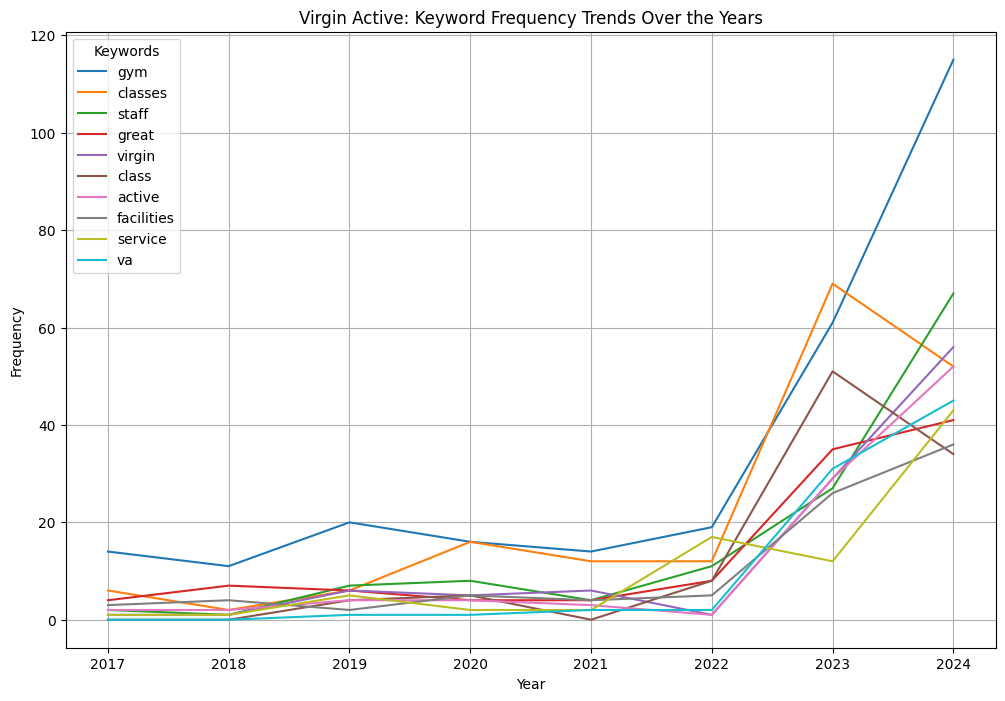

In [28]:
# Line plot for keyword trends
plt.figure(figsize=(12, 8))
for keyword in va_top_keywords:
    plt.plot(va_keyword_trends.index, va_keyword_trends[keyword], label=keyword)

plt.title('Virgin Active: Keyword Frequency Trends Over the Years')
plt.xlabel('Year')
plt.ylabel('Frequency')
plt.legend(title='Keywords')
plt.grid(True)
plt.show()

### Part 2: Word Clouds by Rating
Compare word clouds for high (4-5 stars) and low (1-3 stars) ratings to identify key strengths and weaknesses of other competitors.

In [77]:
fitness_first_positive_reviews = ff_reviews[fitness_first_reviews['rating']>3]
fitness_first_negative_reviews = ff_reviews[fitness_first_reviews['rating']<4]
print('fitness_first_positive_reviews:',fitness_first_positive_reviews.shape)
print('fitness_first_negative_reviews:',fitness_first_negative_reviews.shape)

fitness_first_positive_reviews: (391, 10)
fitness_first_negative_reviews: (97, 10)


In [78]:
virgin_active_positive_reviews = va_reviews[virgin_active_reviews['rating']>3]
virgin_active_negative_reviews = va_reviews[virgin_active_reviews['rating']<4]
print('virgin_active_positive_reviews:',virgin_active_positive_reviews.shape)
print('virgin_active_negative_reviews:',virgin_active_negative_reviews.shape)

virgin_active_positive_reviews: (343, 10)
virgin_active_negative_reviews: (102, 10)


#### Fitness First

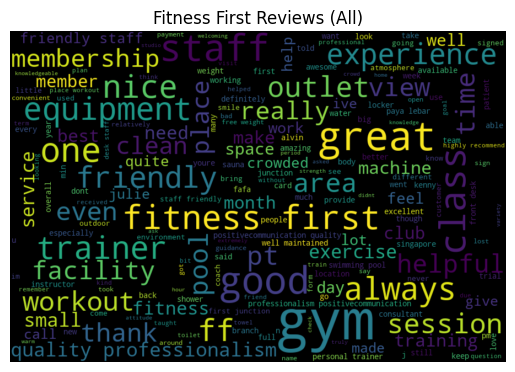

In [103]:
all_ff_reviews = ' '.join([review for review in ff_reviews['Processed_Review']])
RU_wordcloud=WordCloud(width=900, height=600, random_state=21, max_font_size=100).generate(all_ff_reviews)
plt.imshow(RU_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Fitness First Reviews (All)')
plt.show()

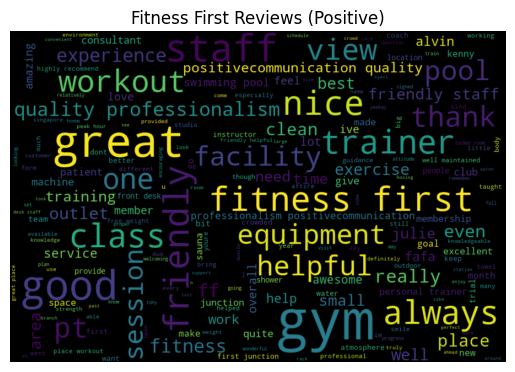

In [102]:
positive_ff_reviews = ' '.join([review for review in fitness_first_positive_reviews['Processed_Review']])
RU_wordcloud=WordCloud(width=900, height=600, random_state=21, max_font_size=100).generate(positive_ff_reviews)
plt.imshow(RU_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Fitness First Reviews (Positive)')
plt.show()

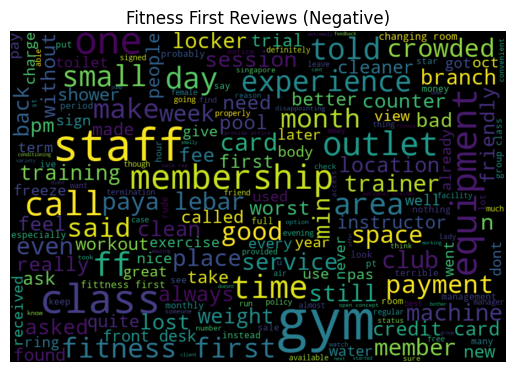

In [100]:
negative_ff_reviews = ' '.join([review for review in fitness_first_negative_reviews['Processed_Review']])
RU_wordcloud=WordCloud(width=900, height=600, random_state=21, max_font_size=100).generate(negative_ff_reviews)
plt.imshow(RU_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Fitness First Reviews (Negative)')
plt.show()

#### Virgin Active

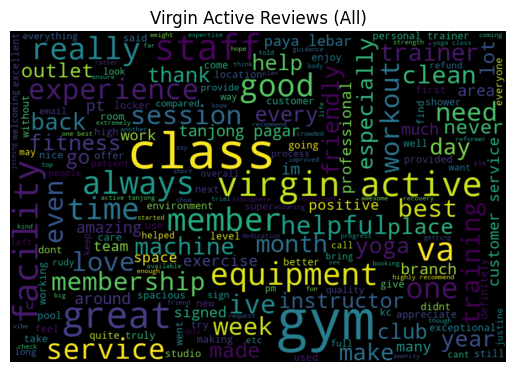

In [99]:
all_va_reviews = ' '.join([review for review in va_reviews['Processed_Review']])
RU_wordcloud=WordCloud(width=900, height=600, random_state=21, max_font_size=100).generate(all_va_reviews)
plt.imshow(RU_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Virgin Active Reviews (All)')
plt.show()

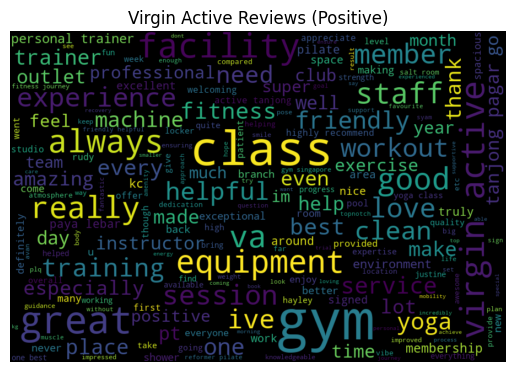

In [97]:
positive_va_reviews = ' '.join([review for review in virgin_active_positive_reviews['Processed_Review']])
RU_wordcloud=WordCloud(width=900, height=600, random_state=21, max_font_size=100).generate(positive_va_reviews)
plt.imshow(RU_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Virgin Active Reviews (Positive)')
plt.show()

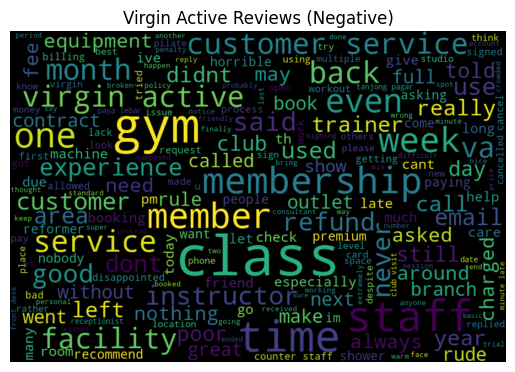

In [98]:
negative_va_reviews = ' '.join([review for review in virgin_active_negative_reviews['Processed_Review']])
RU_wordcloud=WordCloud(width=900, height=600, random_state=21, max_font_size=100).generate(negative_va_reviews)
plt.imshow(RU_wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Virgin Active Reviews (Negative)')
plt.show()

### Part 3: Topic Modeling (LDA)
Discover hidden themes (e.g., equipment, classes, staff) to understand common concerns and strengths.

In [132]:
ff_reviews_copy = ff_reviews.copy()
va_reviews_copy = va_reviews.copy()

#### Fitness First

In [134]:
# 1. Prepare the review text data
reviews = ff_reviews_copy['review'].dropna().tolist()

# 2. Convert the reviews to a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(reviews)

# 3. Apply LDA to extract topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # You can adjust the number of topics
lda.fit(X)

# 4. Get the words associated with each topic
terms = vectorizer.get_feature_names_out()

# Display the top words for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    print([terms[i] for i in topic.argsort()[-10:]])  # Top 10 words for the topic

# 5. Assign topics to reviews
topic_assignments = lda.transform(X)  # Get topic distribution for each review
ff_reviews_copy['lda_topic'] = topic_assignments.argmax(axis=1)

Topic 1:
['staff', 'alvin', 'gym', 'trainer', 'friendly', 'fitness', 'quality', 'communication', 'professionalism', 'positive']
Topic 2:
['equipment', 'area', 'nice', 'swimming', 'great', 'crowded', 'small', 'view', 'gym', 'pool']
Topic 3:
['outlet', 'classes', 'clean', 'great', 'helpful', 'card', 'good', 'friendly', 'gym', 'staff']
Topic 4:
['equipment', 'personal', 'friendly', 'workout', 'good', 'fitness', 'trainer', 'place', 'great', 'gym']
Topic 5:
['service', 'classes', 'good', 'experience', 'class', 'ff', 'gym', 'friendly', 'fitness', 'staff']


#### Virgin Active

In [135]:
# 1. Prepare the review text data
reviews = va_reviews_copy['review'].dropna().tolist()

# 2. Convert the reviews to a document-term matrix using CountVectorizer
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(reviews)

# 3. Apply LDA to extract topics
lda = LatentDirichletAllocation(n_components=5, random_state=42)  # You can adjust the number of topics
lda.fit(X)

# 4. Get the words associated with each topic
terms = vectorizer.get_feature_names_out()

# Display the top words for each topic
for topic_idx, topic in enumerate(lda.components_):
    print(f"Topic {topic_idx + 1}:")
    print([terms[i] for i in topic.argsort()[-10:]])  # Top 10 words for the topic

# 5. Assign topics to reviews
topic_assignments = lda.transform(X)  # Get topic distribution for each review
va_reviews_copy['lda_topic'] = topic_assignments.argmax(axis=1)

Topic 1:
['class', 'helpful', 'really', 'great', 'va', 'equipment', 'staff', 'training', 'classes', 'gym']
Topic 2:
['va', 'great', 'experience', 'good', 'fitness', 'classes', 'active', 'facilities', 'virgin', 'gym']
Topic 3:
['reformer', 'service', 'instructors', 'facilities', 'great', 'gym', 'staff', 'class', 'classes', 'yoga']
Topic 4:
['membership', 'weeks', 'club', 'class', 'staff', 'service', 'virgin', 'classes', 'time', 'gym']
Topic 5:
['day', 'customer', 'love', 'place', 'membership', 'great', 'service', 'class', 'staff', 'gym']


### Part 4: Sentiment by Topic
Analyze sentiment for specific topics (e.g., "equipment" or "classes") that are manually inputted based on the word cloud across different rating levels to pinpoint areas for improvement.

In [131]:
ff_reviews_copy = ff_reviews.copy()
va_reviews_copy = va_reviews.copy()

#### Fitness First

In [122]:
# 1. Perform Sentiment Analysis on 'review' column
def analyze_sentiment(text):
    # Get polarity and subjectivity using TextBlob
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# 2. Define topics (manually or use keyword matching)
topics = ['class', 'staff', 'instructor', 'equipment', 'cleanliness', 'pilates']  # Define topics of interest

# Create a new column for the detected topic in each review
def detect_topic(text, topics):
    for topic in topics:
        if topic.lower() in text.lower():
            return topic
    return 'other'

ff_reviews_copy['Topic'] = ff_reviews_copy['review'].apply(lambda x: detect_topic(x, topics))

# 3. Group by Rating and Topic and calculate the average sentiment scores
ff_sentiment_by_topic = ff_reviews_copy.groupby(['rating', 'Topic']).agg(
    Avg_polarity=('Polarity', 'mean'),
    Avg_subjectivity=('Subjectivity', 'mean')
).reset_index()

ff_sentiment_by_topic.head(2)

rating      Topic  Avg_polarity  Avg_subjectivity
0       1      class     -0.089055          0.643295
1       1  equipment     -0.059821          0.393436

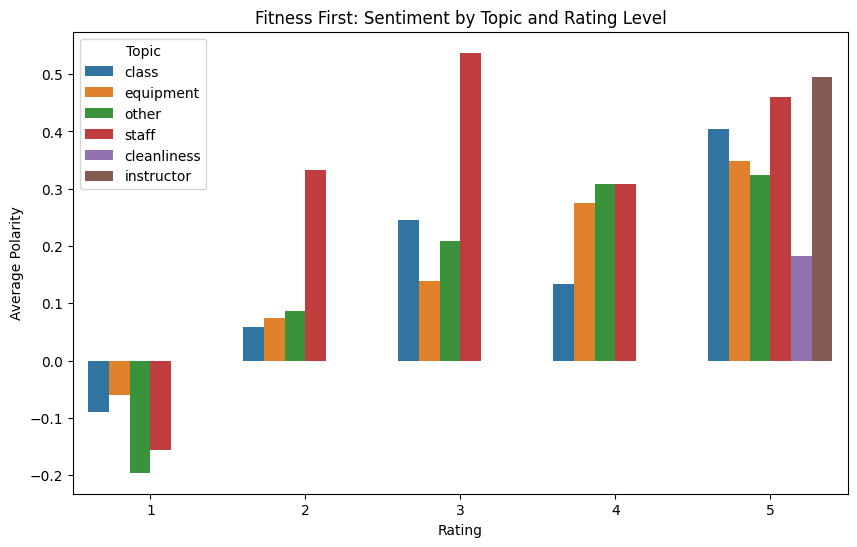

In [123]:
# 4. Visualize the sentiment by topic and rating level 
plt.figure(figsize=(10,6))
sns.barplot(x='rating', y='Avg_polarity', hue='Topic', data=ff_sentiment_by_topic)
plt.title('Fitness First: Sentiment by Topic and Rating Level')
plt.xlabel('Rating')
plt.ylabel('Average Polarity')
plt.show()

#### Virgin Active

In [125]:
# 1. Perform Sentiment Analysis on 'review' column
def analyze_sentiment(text):
    # Get polarity and subjectivity using TextBlob
    blob = TextBlob(text)
    return blob.sentiment.polarity, blob.sentiment.subjectivity

# 2. Define topics (manually or use keyword matching)
topics = ['class', 'staff', 'instructor', 'equipment', 'clean', 'pilates']  # Define topics of interest

# Create a new column for the detected topic in each review
def detect_topic(text, topics):
    for topic in topics:
        if topic.lower() in text.lower():
            return topic
    return 'other'

va_reviews_copy['Topic'] = va_reviews_copy['review'].apply(lambda x: detect_topic(x, topics))

# 3. Group by Rating and Topic and calculate the average sentiment scores
va_sentiment_by_topic = va_reviews_copy.groupby(['rating', 'Topic']).agg(
    Avg_polarity=('Polarity', 'mean'),
    Avg_subjectivity=('Subjectivity', 'mean')
).reset_index()

va_sentiment_by_topic.head(2)

rating  Topic  Avg_polarity  Avg_subjectivity
0       1  class     -0.100377          0.528907
1       1  clean     -0.177778          0.600000

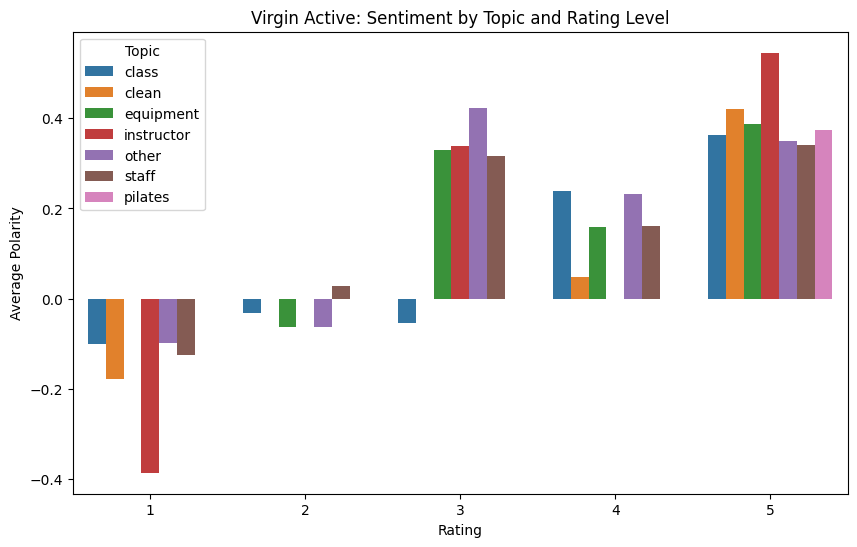

In [126]:
# 4. Visualize the sentiment by topic and rating level 
plt.figure(figsize=(10,6))
sns.barplot(x='rating', y='Avg_polarity', hue='Topic', data=va_sentiment_by_topic)
plt.title('Virgin Active: Sentiment by Topic and Rating Level')
plt.xlabel('Rating')
plt.ylabel('Average Polarity')
plt.show()